In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import sys, time
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
import problems, projection, optimize, util

# 1D problem testing
1. generate blur problem ($K, X, s_b, s_x, M$)
2. compute $R = (X^T X + \lambda I)^{-1}$ directly
3. solve $MRK R^T M^T w = MR s_b$ for $w_d$ directly
4. solve ESI system for $u_m$ with MINRES (gold-standard)
> - check template equation
    1. compute $w_m = M(X^T X + \lambda I) u_m$
    2. compute $r_m = MRK R^T M^T w_m - MR s_b$
> - check MINRES template vs direct template
    3. plot $w_m$ vs $w_d$
    4. compute $\|w_m - w_d\|^2$
5. run POCS on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_p$
> - check template equation
    1. compute $w_p = M(X^T X + \lambda I) u_p$
    2. compute $r_p = MRK R^T M^T w_m - MR s_b$
> - check POCS template vs direct template
    3. plot $w_p$ vs $w_d$
    4. compute $\|w_p - w_d\|^2$
6. run DR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{dr}$
> - check template equation
    1. compute $w_{dr} = M(X^T X + \lambda I) u_{dr}$
    2. compute $r_{dr} = MRK R^T M^T w_m - MR s_b$
> - check POCS template vs direct template
    3. plot $w_{dr}$ vs $w_d$
    4. compute $\|w_{dr} - w_d\|^2$
7. run RAAR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{r}$
> - check template equation
    1. compute $w_{r} = M(X^T X + \lambda I) u_{r}$
    2. compute $r_{r} = MRK R^T M^T w_m - MR s_b$
> - check POCS template vs direct template
    3. plot $w_{r}$ vs $w_d$
    4. compute $\|w_{r} - w_d\|^2$
8. run CG on ESI^T ESI equations
> - check template equation
    1. compute $w_{cg} = M(X^T X + \lambda I) u_{cg}$
    2. compute $r_{cg} = MRK R^T M^T w_m - MR s_b$
> - check CG template vs direct template
    3. plot $w_{cg}$ vs $w_d$
    4. compute $\|w_{cg} - w_d\|^2$
9. run MINRES on ESI3 (expanded ESI) equations
> - check template equation
    1. compute $w_{m3} = M(X^T X + \lambda I) u_{m3}$
    2. compute $r_{m3} = MRK R^T M^T w_m - MR s_b$
> - check CG template vs direct template
    3. plot $w_{m3}$ vs $w_d$
    4. compute $\|w_{m3} - w_d\|^2$

1. generate blur problem ($K, X, s_b, s_x, M$)
---
---

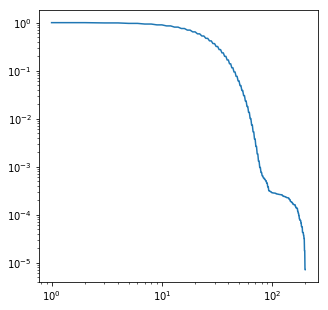

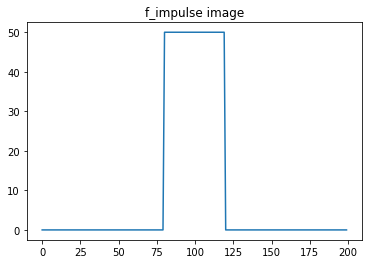

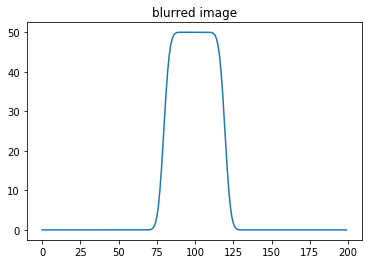

=================== setup ====================
(n_1, n_2, m) = (200, None, 200)
problem       = 1D Blur
lam           = 1.0
B             = <class 'scipy.sparse.dia.dia_matrix'>
ROI pixels    = 60
ROI row       = 100

================== contents ==================
K_diag        = [ 1.  1.  1.  1.  1.]...[ 1.  1.  1.  1.  1.]
sigma         = 3
t             = 10
ESI?          = True
ESIN?         = True
ESI3?         = True
direct?       = True
================= dimensions ==================
Kb shape      = (200, 200)
X shape       = (200, 200)
M shape       = (60, 200)
B shape       = (200, 200)
sx shape      = (200, 1)
sb shape      = (200, 1)
============= system dimensions ===============
ESI_A shape   = (400, 400)
ESI_b shape   = (400,)
ESIN_A shape  = (400, 400)
ESIN_b shape  = (400,)
ESI3_A shape  = (600, 600)
ESI3_b shape  = (600,)


In [3]:
# dims
n_1   = 200    # image
k     = 60     # roi (signal is 50 pixels wide)

# blur
sigma = 3
t     = 10

# optimization
tol   = 1e-15  # tolerance
niter = 1000   # max number of iterations
dr_sl = 1.5    # dr step length
beta  = 0.25   # wtd avg for RAAR

# get max singular value of XtX
tp = problems.Problem(prob='b', n_1=n_1, k=k, ESI=False, ESIN=False, ESI3=False, dir_soln=False)
tp._set_inputs(K_diag=np.ones(tp.n), sigma=sigma, t=t, sparse=True)
tp._set_operators()

Xa  = tp.X.toarray()  # X (as array)
XtX = Xa.T.dot(Xa)
_, s, _ = la.svd(Xa)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
plt.subplot(1,1,1)
plt.loglog(s)
plt.show()

# regularization
msv   = s[0]
lam   = 1*msv

# problem
p = problems.Problem(prob='b', n_1=n_1, k=k, lam=lam, ESI=True, ESIN=True, ESI3=True, dir_soln=True)
p.create_problem(K_diag=np.ones(p.n), sigma=sigma, t=t, sparse=True, plot=True)
p.summarize()

2. compute $R = (X^T X + \lambda I)^{-1}$ directly
---
---

In [4]:
R_d = util.direct_rxn(X=p.X, lam=p.lam, B=None, sparse=True)
R_d_check = spsla.inv(p.X.T.dot(p.X) + p.lam * sps.eye(p.n))
sum(sum(R_d.toarray() - R_d_check.toarray()))

1.2223278873606696e-14

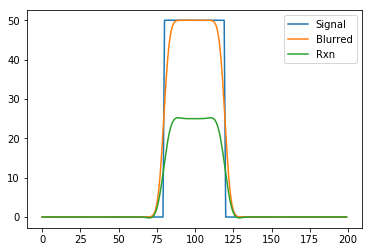

In [5]:
# plot signal, blur, and reconstruction
plt.plot(p.f,label='Signal')
plt.plot(p.sb,label='Blurred')
plt.plot(R_d.dot(p.sb),label='Rxn')
plt.legend()
plt.show()

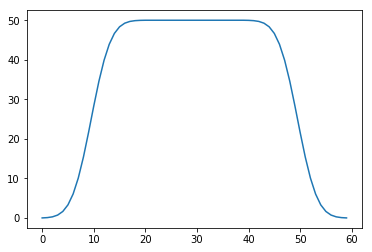

In [6]:
# plot data signal in roi
plt.plot(p.M.dot(p.sb))
plt.show()

3. solve $MRK R^T M^T w = MR s_b$ for $w_d$ directly
---
---

In [7]:
w_d,_,_ = util.direct_solve(Kb=p.Kb, R=R_d, M=p.M, B=None, sb=p.sb, sparse=True)
w_d_check = spsla.inv(p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T)).dot(p.M.dot(R_d).dot(p.sb))
w_d_check_check = spsla.spsolve(p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T), p.M.dot(R_d).dot(p.sb)).reshape(p.k,1)
print(sum(sum(w_d - w_d_check)))
print(sum(sum(w_d - w_d_check_check)))

-1.86734764018e-05
0.0


/Users/jakeroth/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jakeroth/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


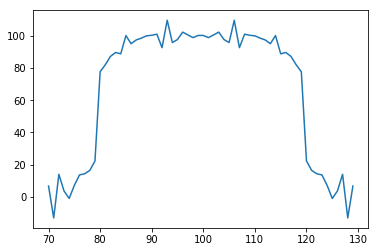

In [8]:
# plot direct template
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.show()

4. solve ESI system for $u_m$ with MINRES (gold-standard)
---
---

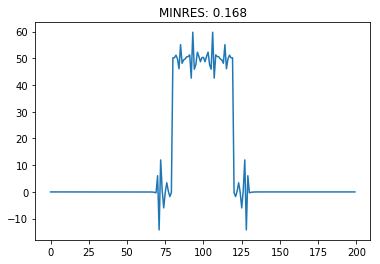

In [9]:
# solve for u
u_m, _, us_m, mr_m, t_m, tt_m = spsla.minres_track(A=p.ESI_A, b=p.ESI_b, tol=tol, maxiter=niter)
plt.title('MINRES: '+ str(round(tt_m,3)))
plt.plot(u_m[0:p.n])
plt.show()

In [10]:
# compute final template w
w_m = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_m, ESI=True)
w_m_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_m[0:p.n]).reshape(p.k,1)
sum(w_m - w_m_check)

array([ 0.])

In [11]:
# compute final template residuals
r_m = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_m) - p.M.dot(R_d).dot(p.sb)
_r_m_ = la.norm(r_m)
print(_r_m_)

1.14116022337e-08


In [12]:
# compute final template error
e_m = w_m - w_d
print('norm final hotelling template error: %s' % round(la.norm(e_m),3))

norm final hotelling template error: 0.631


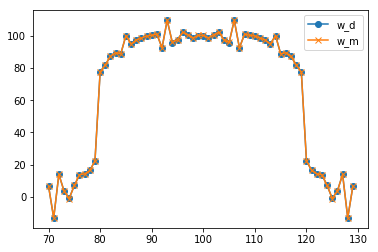

In [13]:
# plot final w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d,marker='o')
plt.plot(px_idx, w_m,marker='x')
plt.legend(['w_d','w_m'])
plt.show()

In [14]:
# compute intermediate hotelling residuals and errors every 10 iterations
hr_m = []
he_m = []
ws_m = []
for uu,i in zip(us_m,range(len(us_m))):
    if i%10 == 0 or i == (len(us_m)-1):
        w = util.calc_hot(X=p.X, B=p.B, lam=p.lam, M=p.M, u=uu, ESI=True)
        ws_m.append(w)
        he_m.append( la.norm(w - w_d) )
        hr_m.append( la.norm(p.M.dot(p.R_direct).dot(p.Kb).dot(p.R_direct.T).dot(p.M.T).dot(w) 
                             - p.M.dot(p.R_direct).dot(p.sb)) )


101


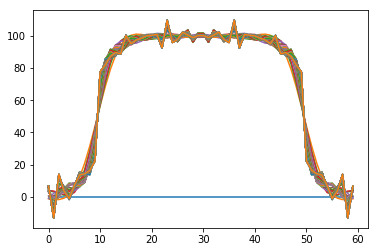

In [15]:
# plot template progression
print(len(ws_m))
for w in ws_m:
    plt.plot(w)
plt.plot(w_d)
plt.show()

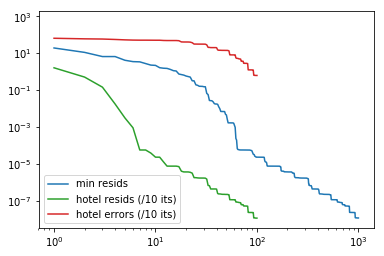

In [16]:
# plot min residuals and hotelling resids & errors
plt.loglog(mr_m,label='min resids')
plt.loglog(np.nan)
plt.loglog(hr_m,label='hotel resids (/10 its)')
plt.loglog(he_m,label='hotel errors (/10 its)')
plt.legend()
plt.show()

5. run POCS on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_p$
---
---

In [17]:
# solve for u
u_p, mr_p, cr_p, t_p, us_p, hr_p, tt_p = projection.pocs(
            p.Kb, p.X, p.sb, p.lam, p.M, max_iter=niter, tol=tol, full_output=1, R=R_d
)

----- POCS -----------------------
(0.0, 'pocs constr 0')
(4196.0661446076901, 'pocs resid 0')
----- POCS -----------------------
    pocs runtime: 11.51


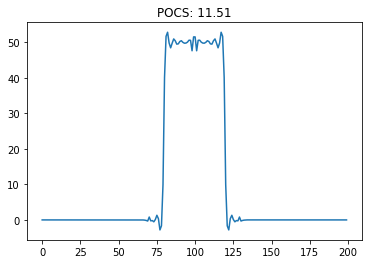

In [18]:
plt.title('POCS: '+ str(round(tt_p,3)))
plt.plot(u_p[0:p.n])
plt.show()

In [19]:
# compute final template w
w_p = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_p)
w_p_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_p).reshape(p.k,1)
sum(w_p - w_p_check)

array([ 0.])

In [20]:
# compute final template residual
r_p = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_p) - p.M.dot(R_d).dot(p.sb)
_r_p_ = la.norm(r_p)
print(_r_p_)

0.0127693809086


In [21]:
# compute final template error
e_p = w_p - w_d
print('norm final hotelling template error: %s' % round(la.norm(e_p),3))

norm final hotelling template error: 41.749


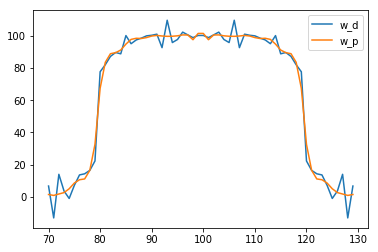

In [22]:
# plot final w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_p)
plt.legend(['w_d','w_p'])
plt.show()

In [23]:
# compute intermediate hotelling residuals and errors every 10 iterations
hr_p = []
he_p = []
ws_p = []
for uu,i in zip(us_p,range(len(us_p))):
    if i%10 == 0 or i == (len(us_p)-1):
        w = util.calc_hot(X=p.X, B=p.B, lam=p.lam, M=p.M, u=uu, ESI=True)
        ws_p.append(w)
        he_p.append( la.norm(w - w_d) )
        hr_p.append( la.norm(p.M.dot(p.R_direct).dot(p.Kb).dot(p.R_direct.T).dot(p.M.T).dot(w) 
                             - p.M.dot(p.R_direct).dot(p.sb)) )


101


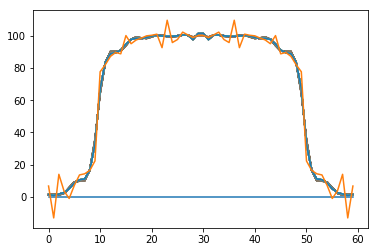

In [24]:
# plot template progression
print(len(ws_p))
for w in ws_p:
    plt.plot(w)
plt.plot(w_d)
plt.show()

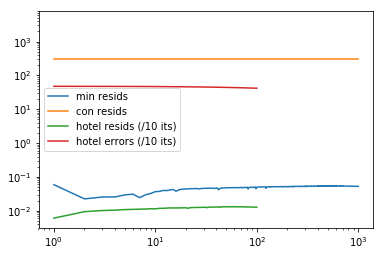

In [25]:
# plot min residuals and hotelling resids & errors
plt.loglog(mr_p,label='min resids')
plt.loglog(cr_p,label='con resids')
plt.loglog(hr_p,label='hotel resids (/10 its)')
plt.loglog(he_p,label='hotel errors (/10 its)')
plt.legend()
plt.show()

6. run DR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{dr}$
---
---

In [26]:
# solve for u
u_dr, mr_dr, cr_dr, _, t_dr, us_dr, hr_dr, tt_dr = projection.dr(
            p.Kb, p.X, p.sb, p.lam, p.M, max_iter=niter, tol=tol, full_output=1, R=R_d, sl=dr_sl
)

----- DR -------------------------
(0.0, 'dr constr 0')
(4196.0661446076901, 'dr min 0')
----- DR -------------------------
    dr runtime: 12.669


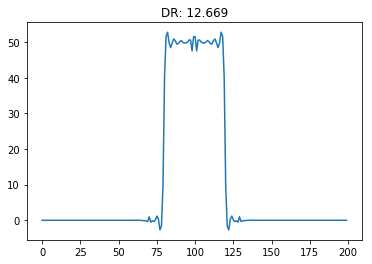

In [27]:
plt.title('DR: '+ str(round(tt_dr,3)))
plt.plot(u_dr[0:p.n])
plt.show()

In [28]:
# compute final template w
w_dr = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_dr)
w_dr_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_dr).reshape(p.k,1)
sum(w_dr - w_dr_check)

array([ 0.])

In [29]:
# compute final template residual
r_dr = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_dr) - p.M.dot(R_d).dot(p.sb)
_r_dr_ = la.norm(r_dr)
print(_r_dr_)

0.0141878564776


In [30]:
# compute final template error
e_dr = w_dr - w_d
print('norm final hotelling template error: %s' % round(la.norm(e_dr),3))

norm final hotelling template error: 41.268


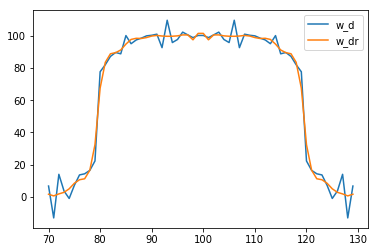

In [31]:
# plot final w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_dr)
plt.legend(['w_d','w_dr'])
plt.show()

In [32]:
# compute intermediate hotelling residuals and errors every 10 iterations
hr_dr = []
he_dr = []
ws_dr = []
for uu,i in zip(us_dr,range(len(us_dr))):
    if i%10 == 0 or i == (len(us_dr)-1):
        w = util.calc_hot(X=p.X, B=p.B, lam=p.lam, M=p.M, u=uu, ESI=True)
        ws_dr.append(w)
        he_dr.append( la.norm(w - w_d) )
        hr_dr.append( la.norm(p.M.dot(p.R_direct).dot(p.Kb).dot(p.R_direct.T).dot(p.M.T).dot(w) 
                             - p.M.dot(p.R_direct).dot(p.sb)) )


102


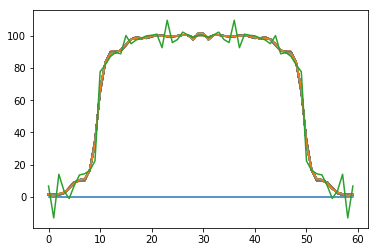

In [33]:
# plot template progression
print(len(ws_dr))
for w in ws_dr:
    plt.plot(w)
plt.plot(w_d)
plt.show()

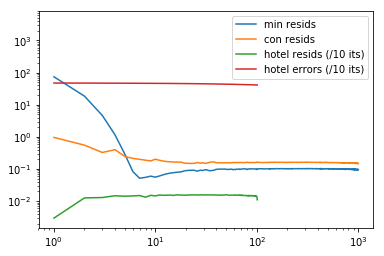

In [34]:
# plot min residuals and hotelling resids & errors
plt.loglog(mr_dr,label='min resids')
plt.loglog(cr_dr,label='con resids')
plt.loglog(hr_dr,label='hotel resids (/10 its)')
plt.loglog(he_dr,label='hotel errors (/10 its)')
plt.legend()
plt.show()

7. run RAAR on $P_1$: $\min_u \|K^{1/2}Xu - K^{-1/2}s_b\|$ and $P_2$: $(I-M^T M)(X^T X + \lambda I)u = 0$ for $u_{r}$
---
---

In [35]:
# solve for u
u_r, mr_r, cr_r, t_r, us_r, hr_r, tt_r = projection.raar(
            p.Kb, p.X, p.sb, p.lam, p.M, beta=beta, max_iter=niter, tol=tol, full_output=1, R=R_d
        )

----- RAAR -----------------------
(0.0, 'raar constr 0')
(4196.0661446076901, 'raar resid 0')
----- RAAR -----------------------
    raar runtime: 11.936


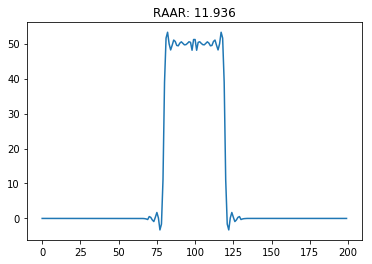

In [36]:
plt.title('RAAR: '+ str(round(tt_r,3)))
plt.plot(u_r[0:p.n])
plt.show()

In [37]:
# compute final template w
w_r = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_r)
w_r_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_r).reshape(p.k,1)
sum(w_r - w_r_check)

array([ 0.])

In [38]:
# compute final template residual
r_r = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_r) - p.M.dot(R_d).dot(p.sb)
_r_r_ = la.norm(r_r)
print(_r_r_)

0.0146602342423


In [39]:
# compute final template errors
e_r = w_r - w_d
print('norm final hotelling template error: %s' % round(la.norm(e_r),3))

norm final hotelling template error: 43.823


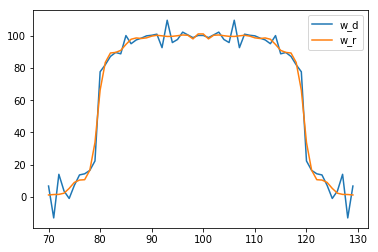

In [40]:
# plot final w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_r)
plt.legend(['w_d','w_r'])
plt.show()

In [41]:
# compute intermediate hotelling residuals and errors every 10 iterations
hr_r = []
he_r = []
ws_r = []
for uu,i in zip(us_r,range(len(us_r))):
    if i%10 == 0 or i == (len(us_r)-1):
        w = util.calc_hot(X=p.X, B=p.B, lam=p.lam, M=p.M, u=uu, ESI=True)
        ws_r.append(w)
        he_r.append( la.norm(w - w_d) )
        hr_r.append( la.norm(p.M.dot(p.R_direct).dot(p.Kb).dot(p.R_direct.T).dot(p.M.T).dot(w) 
                             - p.M.dot(p.R_direct).dot(p.sb)) )


102


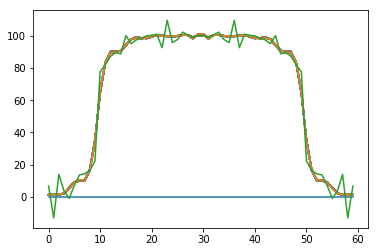

In [42]:
# plot template progression
print(len(ws_r))
for w in ws_r:
    plt.plot(w)
plt.plot(w_d)
plt.show()

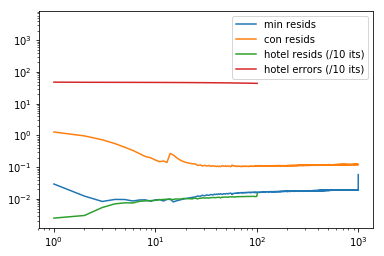

In [43]:
# plot min residuals and hotelling resids & errors
plt.loglog(mr_r,label='min resids')
plt.loglog(cr_r,label='con resids')
plt.loglog(hr_r,label='hotel resids (/10 its)')
plt.loglog(he_r,label='hotel errors (/10 its)')
plt.legend()
plt.show()

8. run CG on ESI^T ESI equations
---
---

In [44]:
# solve for u
cgs = optimize.ConjugateGradientsSolver(A = p.ESIN_A, b = p.ESIN_b, full_output=1)
u_cg, _, min_resids_combined = cgs.solve(tol=tol, max_iter=niter)  # defaults to using all zeros
mr_cg = [r[0] for r in min_resids_combined]
tt_cg = min_resids_combined[-1][1]
us_cg = cgs.path(tol=tol,max_iter=niter)


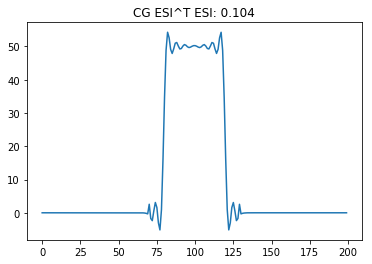

In [45]:
plt.title('CG ESI^T ESI: '+ str(round(tt_cg,3)))
plt.plot(u_cg[0:p.n])
plt.show()

In [46]:
# compute final template w
w_cg = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_cg, ESI=True)
w_cg_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_cg[0:p.n]).reshape(p.k,1)
sum(w_cg - w_cg_check)

array([ 0.])

In [47]:
# compute final template residual
r_cg = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_cg) - p.M.dot(R_d).dot(p.sb)
_r_cg_ = la.norm(r_cg)
print(_r_cg_)

1.65640988803e-05


In [48]:
# compute final template error
e_cg = w_cg - w_d
print('norm final hotelling template error: %s' % round(la.norm(e_cg),3))

norm final hotelling template error: 51.375


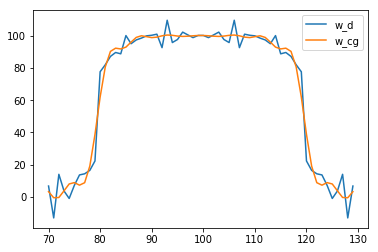

In [49]:
# plot final w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_cg)
plt.legend(['w_d','w_cg'])
plt.show()

In [50]:
# compute intermediate hotelling residuals and errors every 10 iterations
hr_cg = []
he_cg = []
ws_cg = []
for uu,i in zip(us_cg,range(len(us_cg))):
    if i%10 == 0 or i == (len(us_cg)-1):
        w = util.calc_hot(X=p.X, B=p.B, lam=p.lam, M=p.M, u=uu, ESI=True)
        ws_cg.append(w)
        he_cg.append( la.norm(w - w_d) )
        hr_cg.append( la.norm(p.M.dot(p.R_direct).dot(p.Kb).dot(p.R_direct.T).dot(p.M.T).dot(w) 
                             - p.M.dot(p.R_direct).dot(p.sb)) )


101


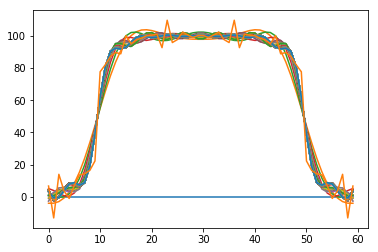

In [51]:
# plot template progression
print(len(ws_cg))
for w in ws_cg:
    plt.plot(w)
plt.plot(w_d)
plt.show()

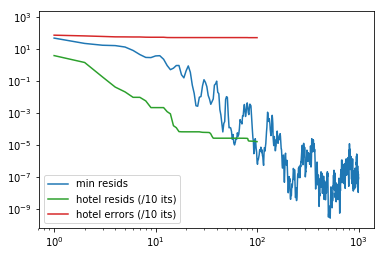

In [52]:
# plot min residuals and hotelling resids & errors
plt.loglog(mr_cg,label='min resids')
plt.loglog(np.nan)
plt.loglog(hr_cg,label='hotel resids (/10 its)')
plt.loglog(he_cg,label='hotel errors (/10 its)')
plt.legend()
plt.show()

9. run MINRES on ESI3 (expanded ESI) equations
---
---

In [53]:
# solve for u
u_m3, _, us_m3, mr_m3, times_m3, tt_m3 = spsla.minres_track(A=p.ESI3_A, b=p.ESI3_b, tol=tol, maxiter=niter)


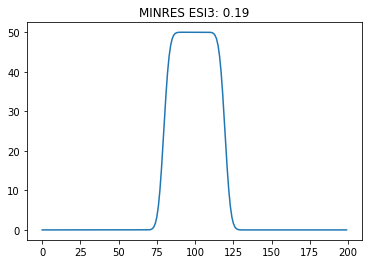

In [54]:
plt.title('MINRES ESI3: '+ str(round(tt_m3,3)))
plt.plot(u_m3[0:p.n])
plt.show()

In [55]:
# compute final template w
w_m3 = util.calc_hot(X=p.X, B=None, lam=p.lam, M=p.M, u=u_m3, ESI=True)
w_m3_check = p.M.dot(p.X.T.dot(p.X) + p.lam*sps.eye(p.n)).dot(u_m3[0:p.n]).reshape(p.k,1)
sum(w_m3 - w_m3_check)

array([ 0.])

In [56]:
# compute final template residual
r_m3 = p.M.dot(R_d).dot(p.Kb).dot(R_d.T).dot(p.M.T).dot(w_m3) - p.M.dot(R_d).dot(p.sb)
_r_m3_ = la.norm(r_m3)
print(_r_m3_)

7.49690002063


In [57]:
# compute final template error
e_m3 = w_m3 - w_d
print('norm final hotelling template error: %s' % round(la.norm(e_m3),3))

norm final hotelling template error: 75.047


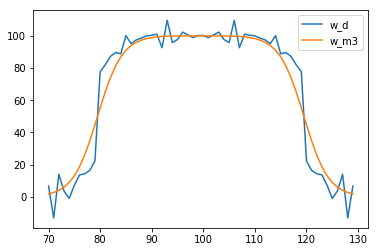

In [58]:
# plot final w
px_idx = [(p.n-p.k)/2 + i for i in range(p.k)]
plt.plot(px_idx, w_d)
plt.plot(px_idx, w_m3)
plt.legend(['w_d','w_m3'])
plt.show()

In [59]:
# compute intermediate hotelling residuals and errors every 10 iterations
hr_m3 = []
he_m3 = []
ws_m3 = []
for uu,i in zip(us_m3,range(len(us_m3))):
    if i%10 == 0 or i == (len(us_m3)-1):
        w = util.calc_hot(X=p.X, B=p.B, lam=p.lam, M=p.M, u=uu, ESI=True)
        ws_m3.append(w)
        he_m3.append( la.norm(w - w_d) )
        hr_m3.append( la.norm(p.M.dot(p.R_direct).dot(p.Kb).dot(p.R_direct.T).dot(p.M.T).dot(w) 
                             - p.M.dot(p.R_direct).dot(p.sb)) )


101


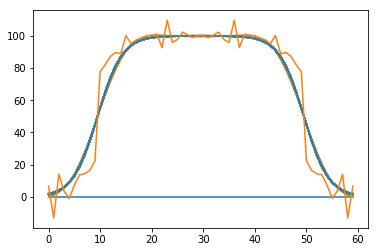

In [60]:
# plot template progression
print(len(ws_m3))
for w in ws_m3:
    plt.plot(w)
plt.plot(w_d)
plt.show()

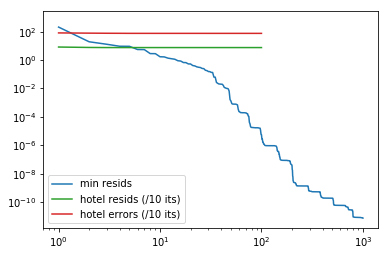

In [61]:
# plot min residuals and hotelling resids & errors
plt.loglog(mr_m3,label='min resids')
plt.loglog(np.nan)
plt.loglog(hr_m3,label='hotel resids (/10 its)')
plt.loglog(he_m3,label='hotel errors (/10 its)')
plt.legend()
plt.show()